## Case Study #4 - Data Bank

#### Problem Statement
There is a new innovation in the financial industry called Neo-Banks: new aged digital only banks without physical branches.

Danny thought that there should be some sort of intersection between these new age banks, cryptocurrency and the data world…so he decides to launch a new initiative - Data Bank!

Data Bank runs just like any other digital bank - but it isn’t only for banking activities, they also have the world’s most secure distributed data storage platform!

Customers are allocated cloud data storage limits which are directly linked to how much money they have in their accounts. There are a few interesting caveats that go with this business model, and this is where the Data Bank team need your help!

The management team at Data Bank want to increase their total customer base - but also need some help tracking just how much data storage their customers will need.

This case study is all about calculating metrics, growth and helping the business analyse their data in a smart way to better forecast and plan for their future developments!

#### Entity Relationship Diagram

![week4.png](week4.png)

Import modules

In [133]:
# SQL Engine imports
from dotenv import load_dotenv
import os
import psycopg2
from sqlalchemy import create_engine
from sqlalchemy.sql import text

# Python data analysis imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

Initialize SQL

In [134]:
load_dotenv()
user = os.environ.get("USER")
pw = os.environ.get("PASS")
db = os.environ.get("DB")
host = os.environ.get("HOST")
api = os.environ.get("API")
port = 5432
schema = 'data_bank'

In [135]:
uri = f"postgresql+psycopg2://{user}:{pw}@{host}:{port}/{db}"
alchemyEngine = create_engine(uri)
conn = alchemyEngine.connect()

Verify tables

In [136]:
rs = conn.execute(text(f"SELECT table_name FROM information_schema.tables WHERE table_schema='{schema}'"))
tables = [table[0] for table in rs.fetchall()]
print(f'The tables in the database are: \n- {'\n- '.join(tables)}')

The tables in the database are: 
- regions
- customer_nodes
- customer_transactions


Fetch table information

In [137]:
for table in tables:
    print("=================================")
    print(f'Table [{table}]')
    df = pd.read_sql_query(f'SELECT * FROM {schema}.{table} LIMIT 5', conn)
    print(f'Dimensions: {df.shape[0]} rows x {df.shape[1]} columns\n')
    print(df.head())
    info_df = pd.DataFrame.from_dict({'Datatypes':df.dtypes, 'NULL count':df.isna().sum()})
    print()
    print(info_df)
    print()

Table [regions]
Dimensions: 5 rows x 2 columns

   region_id region_name
0          1   Australia
1          2     America
2          3      Africa
3          4        Asia
4          5      Europe

            Datatypes  NULL count
region_id       int64           0
region_name    object           0

Table [customer_nodes]
Dimensions: 5 rows x 5 columns

   customer_id  region_id  node_id  start_date    end_date
0            1          3        4  2020-01-02  2020-01-03
1            2          3        5  2020-01-03  2020-01-17
2            3          5        4  2020-01-27  2020-02-18
3            4          5        4  2020-01-07  2020-01-19
4            5          3        3  2020-01-15  2020-01-23

            Datatypes  NULL count
customer_id     int64           0
region_id       int64           0
node_id         int64           0
start_date     object           0
end_date       object           0

Table [customer_transactions]
Dimensions: 5 rows x 4 columns

   customer_id    txn

In [138]:
def query(stmt: str):
    """Executes a given SQL statement and returns a Pandas DataFrame given the results.
    
    Parameters
    ----------
    stmt: str
        The SQL statement to be executed
    """
    global conn
    result = pd.read_sql_query(stmt, conn)
    return result

## Case Study Questions

The following case study questions include some general data exploration analysis for the nodes and transactions before diving right into the core business questions and finishes with a challenging final request!

**A. Customer Nodes Exploration**

Q1: How many unique nodes are there on the Data Bank system?

In [139]:
query(f'''
    SELECT COUNT(DISTINCT node_id)
    FROM data_bank.customer_nodes 
''')

,count
0,5


Q2: What is the number of nodes per region?

In [140]:
query('''
    SELECT r.region_id, r.region_name, COUNT(DISTINCT cn.node_id)
    FROM data_bank.regions r
        JOIN data_bank.customer_nodes cn USING (region_id)
    GROUP BY region_id, region_name
    ORDER BY region_id
''')

,region_id,region_name,count
0,1,Australia,5
1,2,America,5
2,3,Africa,5
3,4,Asia,5
4,5,Europe,5


Q3: How many customers are allocated to each region?

In [141]:
query('''
    SELECT 
        region_id, 
        COUNT(customer_id) AS customer_count
    FROM data_bank.customer_nodes
    GROUP BY region_id
    ORDER BY region_id
''')

,region_id,customer_count
0,1,770
1,2,735
2,3,714
3,4,665
4,5,616


Q4: How many days on average are customers reallocated to a different node?

- This problem can be solved by first obtaining the number of days a customer stayed in each node

In [142]:
query('''
    WITH node_days AS (
    SELECT 
      customer_id, 
      region_id,
      node_id,
      end_date - start_date AS days_in_node
    FROM data_bank.customer_nodes
    WHERE end_date != '9999-12-31' -- Exclude the active records
  ), 
  total_node_days AS (
    SELECT 
      customer_id,
      region_id, 
      node_id,
      SUM(days_in_node) AS total_days_in_node
    FROM node_days
    GROUP BY customer_id, region_id, node_id
  )

  SELECT ROUND(AVG(total_days_in_node),2) AS avg_node_reallocation_days
  FROM total_node_days;
''')

,avg_node_reallocation_days
0,23.57


Q5: What is the median, 80th and 95th percentile for this same reallocation days metric for each region?

- Same approach as Q4, but use PERCENTILE_CONT() to get the percentile values.

In [143]:
query('''
    WITH node_days AS (
        SELECT 
            customer_id, 
            region_id,
            node_id,
            end_date - start_date AS days_in_node
        FROM data_bank.customer_nodes
        WHERE end_date != '9999-12-31' -- Exclude the active records
    ), 
    total_node_days AS (
        SELECT 
            customer_id,
            region_id, 
            node_id,
            SUM(days_in_node) AS total_days_in_node
        FROM node_days
        GROUP BY customer_id, region_id, node_id
    )
    SELECT
        PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY total_days_in_node) AS median_days,
        PERCENTILE_CONT(0.80) WITHIN GROUP (ORDER BY total_days_in_node) AS perc_80_days,
        PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY total_days_in_node) AS perc_95_days
    FROM
        total_node_days
''')

,median_days,perc_80_days,perc_95_days
0,22.0,34.0,52.0


- Median: 22 days
- 80th percentile: 34 days
- 95th percentile: 52 days

**B. Customer Transactions**

Q6: What is the unique count and total amount for each transaction type?

In [144]:
q6_df = query('''
    SELECT
        txn_type, 
        COUNT(customer_id) AS num_transactions, 
        SUM(txn_amount) AS total_amount
    FROM data_bank.customer_transactions
    GROUP BY txn_type;
''')
q6_df

,txn_type,num_transactions,total_amount
0,purchase,1617,806537
1,withdrawal,1580,793003
2,deposit,2671,1359168


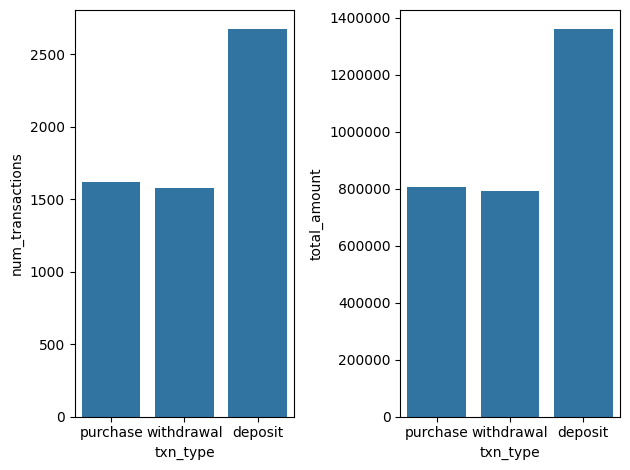

In [145]:
fig, (a0, a1) = plt.subplots(1, 2, sharey=False)
sns.barplot(data=q6_df, x='txn_type', y='num_transactions', ax=a0)
sns.barplot(data=q6_df, x='txn_type', y='total_amount', ax=a1)
plt.ticklabel_format(style='plain', axis='y')
fig.tight_layout()
plt.show()

Q7: What is the average total historical deposit counts and amounts for all customers?

In [146]:
query('''
    WITH deposits AS (
    SELECT 
        customer_id, 
        COUNT(customer_id) AS txn_count, 
        AVG(txn_amount) AS avg_amount
    FROM data_bank.customer_transactions
    WHERE txn_type = 'deposit'
    GROUP BY customer_id
    )

    SELECT 
        ROUND(AVG(txn_count)) AS avg_deposit_count, 
        ROUND(AVG(avg_amount)) AS avg_deposit_amt
    FROM deposits;
''')

,avg_deposit_count,avg_deposit_amt
0,5.0,509.0


Bonus: Visualizing the distribution of deposit counts and amounts per customer:

In [147]:
q7b_df = query('''
    SELECT 
        customer_id, 
        COUNT(customer_id) AS txn_count, 
        AVG(txn_amount) AS avg_amount
    FROM data_bank.customer_transactions
    WHERE txn_type = 'deposit'
    GROUP BY customer_id
    ORDER BY avg_amount DESC
''')
q7b_df

,customer_id,txn_count,avg_amount
0,92,1,985.000000
1,252,1,982.000000
2,84,1,968.000000
3,401,2,959.500000
4,260,3,953.666667
...,...,...,...
495,75,2,147.000000
496,431,2,129.500000
497,71,1,128.000000
498,466,3,95.333333


- Observation: Highest average is 985.00 per transaction while lowest average is 14.00 per transaction. Both of these extreme values were achieved by just 1 deposit from the respective customers.

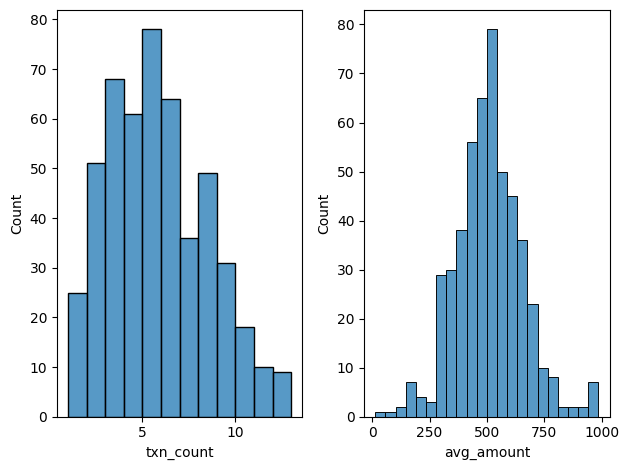

In [148]:
fig, (a0, a1) = plt.subplots(1, 2, sharey=False)
sns.histplot(data=q7b_df, x='txn_count', ax=a0)
sns.histplot(data=q7b_df, x='avg_amount', ax=a1)
plt.ticklabel_format(style='plain', axis='y')
fig.tight_layout()
plt.show()

- The distribution for average deposit amount looked like a normal distribution.

Q8: For each month - how many Data Bank customers make more than 1 deposit and either 1 purchase or 1 withdrawal in a single month?

- Approach: Use a CTE to tally the number of transactions per type for each combination of customer_id and month.

In [149]:
query('''
    WITH transactions_per_month_cte AS(
        SELECT
            customer_id,
            DATE_PART('month', txn_date) AS month,
            SUM(CASE WHEN txn_type = 'deposit' THEN 1 ELSE 0 END) AS num_deposits,
            SUM(CASE WHEN txn_type = 'purchase' THEN 1 ELSE 0 END) AS num_purchases,
            SUM(CASE WHEN txn_type = 'withdrawal' THEN 1 ELSE 0 END) AS num_withdrawals
        FROM data_bank.customer_transactions
        GROUP BY customer_id, DATE_PART('month', txn_date)
    ) 
    SELECT
        month::INT,
        COUNT(DISTINCT customer_id) AS num_customers
    FROM 
        transactions_per_month_cte
    WHERE
        num_deposits > 1 AND (num_purchases >= 1 OR num_withdrawals >= 1)
    GROUP BY month
    ORDER BY month
''')

,month,num_customers
0,1,168
1,2,181
2,3,192
3,4,70


Q9: What is the closing balance for each customer at the end of the month?

- First create a CTE to get the sum of deposits minus sum of purchases and sum of withdrawals, grouped by customer and end of month to get the monthly changes.

In [150]:
query('''
    SELECT 
        customer_id,
        (DATE_TRUNC('month', txn_date) + INTERVAL '1 MONTH - 1 DAY')::DATE AS end_of_month, 
        SUM(CASE 
            WHEN txn_type = 'withdrawal' THEN -txn_amount
            WHEN txn_type = 'purchase' THEN -txn_amount
            ELSE txn_amount 
        END) AS flow_change
    FROM data_bank.customer_transactions
    GROUP BY customer_id, end_of_month 
    ORDER BY customer_id, end_of_month 
''')

,customer_id,end_of_month,flow_change
0,1,2020-01-31,312
1,1,2020-03-31,-952
2,2,2020-01-31,549
3,2,2020-03-31,61
4,3,2020-01-31,144
...,...,...,...
1715,499,2020-02-29,1719
1716,499,2020-03-31,-816
1717,500,2020-01-31,1594
1718,500,2020-02-29,1387


- Next, we can apply running total to get the cumulative balance at the end of every month (only for the months containing transactions).
- HACK: We can generate "0.00 amount of deposit" transactions (for Jan to April 2020) just to ensure all months will be included per customer. So let's generate this table first.

In [155]:
query('''
    SELECT MIN(txn_date), MAX(txn_date)
    FROM data_bank.customer_transactions
''')

,min,max
0,2020-01-01,2020-04-28


In [156]:
query('''
    SELECT 
        DISTINCT customer_id,
        ('2020-01-01'::DATE + GENERATE_SERIES(0,3) * INTERVAL '1 MONTH') AS txn_date,
        'deposit' AS txn_type,
        0 AS txn_amount
    FROM data_bank.customer_transactions
    ORDER BY customer_id, txn_date
''')

,customer_id,txn_date,txn_type,txn_amount
0,1,2020-01-01,deposit,0
1,1,2020-02-01,deposit,0
2,1,2020-03-01,deposit,0
3,1,2020-04-01,deposit,0
4,2,2020-01-01,deposit,0
...,...,...,...,...
1995,499,2020-04-01,deposit,0
1996,500,2020-01-01,deposit,0
1997,500,2020-02-01,deposit,0
1998,500,2020-03-01,deposit,0


- Now we perform the first query again, this time merging with the dummy table created right above.

In [157]:
query('''
    WITH transactions_with_missing_months_filled_cte AS(
        SELECT * FROM data_bank.customer_transactions
        UNION
        SELECT 
            DISTINCT customer_id,
            ('2020-01-01'::DATE + GENERATE_SERIES(0,3) * INTERVAL '1 MONTH') AS txn_date,
            'deposit' AS txn_type,
            0 AS txn_amount
        FROM data_bank.customer_transactions
    )   
    SELECT 
        customer_id,
        (DATE_TRUNC('month', txn_date) + INTERVAL '1 MONTH - 1 DAY')::DATE AS end_of_month, 
        SUM(CASE 
            WHEN txn_type = 'withdrawal' THEN -txn_amount
            WHEN txn_type = 'purchase' THEN -txn_amount
            ELSE txn_amount 
        END) AS flow_change
    FROM transactions_with_missing_months_filled_cte
    GROUP BY customer_id, end_of_month 
    ORDER BY customer_id, end_of_month 
''')

,customer_id,end_of_month,flow_change
0,1,2020-01-31,312
1,1,2020-02-29,0
2,1,2020-03-31,-952
3,1,2020-04-30,0
4,2,2020-01-31,549
...,...,...,...
1995,499,2020-04-30,0
1996,500,2020-01-31,1594
1997,500,2020-02-29,1387
1998,500,2020-03-31,-730


- As we can see, we now have complete rows (500 customers * 4 months = 2000 rows). Yay!
- We can now get the cumulative total per month by applying a window function in the main query.

In [158]:
query('''
    WITH transactions_with_missing_months_filled_cte AS(
        SELECT * FROM data_bank.customer_transactions
        UNION
        SELECT 
            DISTINCT customer_id,
            ('2020-01-01'::DATE + GENERATE_SERIES(0,3) * INTERVAL '1 MONTH') AS txn_date,
            'deposit' AS txn_type,
            0 AS txn_amount
        FROM data_bank.customer_transactions
    ),
    flow_changes_cte AS(   
        SELECT 
            customer_id,
            (DATE_TRUNC('month', txn_date) + INTERVAL '1 MONTH - 1 DAY')::DATE AS end_of_month, 
            SUM(CASE 
                WHEN txn_type = 'withdrawal' THEN -txn_amount
                WHEN txn_type = 'purchase' THEN -txn_amount
                ELSE txn_amount 
            END) AS flow_change
        FROM transactions_with_missing_months_filled_cte
        GROUP BY customer_id, end_of_month 
        ORDER BY customer_id, end_of_month
    ) 
    SELECT
        customer_id,
        end_of_month,
        flow_change,
        SUM(flow_change) OVER (
            PARTITION BY customer_id ORDER BY end_of_month      -- Window function
            ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW    -- Cumulative sum
        ) AS ending_balance
    FROM
        flow_changes_cte
''')

,customer_id,end_of_month,flow_change,ending_balance
0,1,2020-01-31,312,312.0
1,1,2020-02-29,0,312.0
2,1,2020-03-31,-952,-640.0
3,1,2020-04-30,0,-640.0
4,2,2020-01-31,549,549.0
...,...,...,...,...
1995,499,2020-04-30,0,599.0
1996,500,2020-01-31,1594,1594.0
1997,500,2020-02-29,1387,2981.0
1998,500,2020-03-31,-730,2251.0


Bonus: Get overall ending balances and flow changes from all customers by month

In [160]:
q9b_df = query('''
    WITH transactions_with_missing_months_filled_cte AS(
        SELECT * FROM data_bank.customer_transactions
        UNION
        SELECT 
            DISTINCT customer_id,
            ('2020-01-01'::DATE + GENERATE_SERIES(0,3) * INTERVAL '1 MONTH') AS txn_date,
            'deposit' AS txn_type,
            0 AS txn_amount
        FROM data_bank.customer_transactions
    ),
    flow_changes_cte AS(   
        SELECT 
            customer_id,
            (DATE_TRUNC('month', txn_date) + INTERVAL '1 MONTH - 1 DAY')::DATE AS end_of_month, 
            SUM(CASE 
                WHEN txn_type = 'withdrawal' THEN -txn_amount
                WHEN txn_type = 'purchase' THEN -txn_amount
                ELSE txn_amount 
            END) AS flow_change
        FROM transactions_with_missing_months_filled_cte
        GROUP BY customer_id, end_of_month 
        ORDER BY customer_id, end_of_month
    ), 
    ending_balances_cte AS(
        SELECT
            customer_id,
            end_of_month,
            flow_change,
            SUM(flow_change) OVER (
                PARTITION BY customer_id ORDER BY end_of_month      -- Window function
                ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW    -- Cumulative sum
            ) AS ending_balance
        FROM
            flow_changes_cte
    )
    SELECT
        end_of_month,
        SUM(flow_change) AS overall_flow_change,
        SUM(ending_balance) AS overall_ending_balance
    FROM
        ending_balances_cte
    GROUP BY end_of_month
    ORDER BY end_of_month
''')
q9b_df

,end_of_month,overall_flow_change,overall_ending_balance
0,2020-01-31,126091.0,126091.0
1,2020-02-29,-139799.0,-13708.0
2,2020-03-31,-170884.0,-184592.0
3,2020-04-30,-55780.0,-240372.0


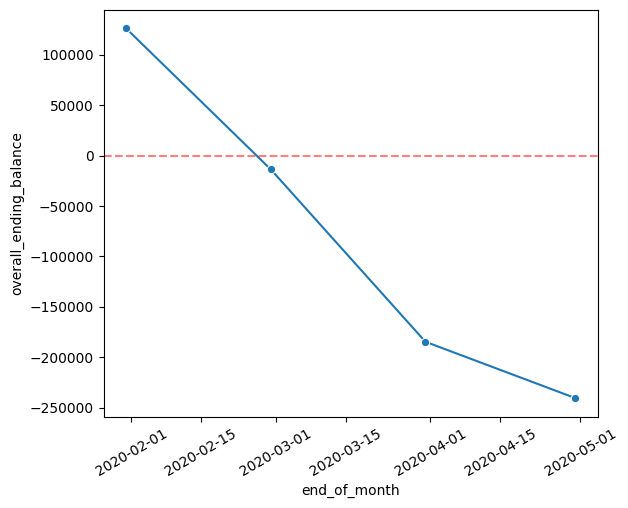

In [174]:
sns.lineplot(data=q9b_df, x='end_of_month', y='overall_ending_balance', marker='o')
plt.axhline(y=0, color='red',alpha=0.5,linestyle='--')
plt.tight_layout()
plt.xticks(rotation=30)
plt.show()

- Apparently, the bank went into a negative balance starting February 2020. Probably this can be attributed to the customers withdrawing a lot of money to secure as much goods they can to survive the COVID-19 lockdown!

Q10: What is the percentage of customers who increase their closing balance by more than 5%?

**C: Data Allocation Challenge**

Q11: To test out a few different hypotheses - the Data Bank team wants to run an experiment where different groups of customers would be allocated data using 3 different options:
- Option 1: data is allocated based off the amount of money at the end of the previous month
- Option 2: data is allocated on the average amount of money kept in the account in the previous 30 days
- Option 3: data is updated real-time

For this multi-part challenge question - you have been requested to generate the following data elements to help the Data Bank team estimate how much data will need to be provisioned for each option:
- running customer balance column that includes the impact each transaction
- customer balance at the end of each month
- minimum, average and maximum values of the running balance for each customer

Using all of the data available - how much data would have been required for each option on a monthly basis?

**D. Extra Challenge**

Data Bank wants to try another option which is a bit more difficult to implement - they want to calculate data growth using an interest calculation, just like in a traditional savings account you might have with a bank.

If the annual interest rate is set at 6% and the Data Bank team wants to reward its customers by increasing their data allocation based off the interest calculated on a daily basis at the end of each day, how much data would be required for this option on a monthly basis?

Special notes:
- Data Bank wants an initial calculation which does not allow for compounding interest, however they may also be interested in a daily compounding interest calculation so you can try to perform this calculation if you have the stamina!

**E. Extension Request**

The Data Bank team wants you to use the outputs generated from the above sections to create a quick Powerpoint presentation which will be used as marketing materials for both external investors who might want to buy Data Bank shares and new prospective customers who might want to bank with Data Bank.
1. Using the outputs generated from the customer node questions, generate a few headline insights which Data Bank might use to market it’s world-leading security features to potential investors and customers.
2. With the transaction analysis - prepare a 1 page presentation slide which contains all the relevant information about the various options for the data provisioning so the Data Bank management team can make an informed decision.

**Conclusion**

This case study aims to mimic traditional banking style transactions data but with a twist - hopefully it can give you some insight into the types of datasets you might encounter in a customer banking scenario.